In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import datetime as dt
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

import os
import dotenv
dotenv.load_dotenv()

from pathlib import Path

# Preprocessing

In [6]:
CSV_OPPRC = 'optionm_spx_opprc_20220831-20230831.csv'
CSV_PATH = Path(os.getenv('CSV_PATH'))

In [63]:
dat_raw = pd.read_csv(CSV_PATH / CSV_OPPRC)
dat_raw.describe()

,secid,symbol_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,forward_price,root,suffix,cusip,sic,index_flag,exchange_d,class,industry_group,am_set_flag
count,4758843.0,4758843.0,4.758843e+06,4.758843e+06,4.758843e+06,4.758843e+06,4.758843e+06,4.284172e+06,4.284172e+06,4.284172e+06,...,0.0,0.0,0.0,4758843.0,4758843.0,4758843.0,4758843.0,0.0,0.0,0.0
mean,108105.0,1.0,3.836070e+06,3.750191e+02,3.794992e+02,1.450367e+02,9.378472e+02,2.855579e-01,9.466058e-02,7.506155e-04,...,NaN,NaN,NaN,64881510.0,9999.0,1.0,32768.0,NaN,NaN,NaN
std,0.0,0.0,1.005504e+06,6.218828e+02,6.279038e+02,1.660133e+03,4.014563e+03,2.898833e-01,5.752222e-01,9.565353e-04,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
min,108105.0,1.0,1.000000e+05,0.000000e+00,5.000000e-02,0.000000e+00,0.000000e+00,3.264800e-02,-1.000000e+00,0.000000e+00,...,NaN,NaN,NaN,64881510.0,9999.0,1.0,32768.0,NaN,NaN,NaN
25%,108105.0,1.0,3.440000e+06,1.450000e+01,1.490000e+01,0.000000e+00,1.000000e+00,1.767960e-01,-2.421590e-01,1.300000e-04,...,NaN,NaN,NaN,64881510.0,9999.0,1.0,32768.0,NaN,NaN,NaN
50%,108105.0,1.0,3.905000e+06,1.195000e+02,1.215000e+02,0.000000e+00,3.900000e+01,2.288840e-01,-3.010000e-04,4.500000e-04,...,NaN,NaN,NaN,64881510.0,9999.0,1.0,32768.0,NaN,NaN,NaN
75%,108105.0,1.0,4.300000e+06,4.445000e+02,4.507000e+02,7.000000e+00,3.200000e+02,2.954620e-01,6.421832e-01,1.002000e-03,...,NaN,NaN,NaN,64881510.0,9999.0,1.0,32768.0,NaN,NaN,NaN
max,108105.0,1.0,1.200000e+07,6.456000e+03,6.608900e+03,1.357660e+05,1.783570e+05,8.997614e+00,9.999980e-01,1.995000e-02,...,NaN,NaN,NaN,64881510.0,9999.0,1.0,32768.0,NaN,NaN,NaN


In [64]:
idx_filter_bid = dat_raw['best_bid'] > 0.0
idx_filter_spread = dat_raw['best_offer'] - dat['best_bid'] >= 0.0
idx_filter_open_interest = dat_raw['open_interest'] > 0.0
idx_filter_volume = dat_raw['volume'] > 0.0
idx_filter_impl_vol = ~ dat_raw['impl_volatility'].isna()
idx_filter_leverage = dat_raw['delta'].abs().between(*np.nanquantile(dat_raw['delta'].abs(), [0.01, 0.99]))

idx_filter = (
    idx_filter_bid & 
    idx_filter_spread & 
    idx_filter_open_interest & 
    idx_filter_volume &
    idx_filter_impl_vol & 
    idx_filter_leverage
)

In [65]:
dat_raw.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'forward_price', 'expiry_indicator', 'root', 'suffix', 'cusip',
       'ticker', 'sic', 'index_flag', 'exchange_d', 'class', 'issue_type',
       'industry_group', 'issuer', 'div_convention', 'exercise_style',
       'am_set_flag'],
      dtype='object')

In [66]:
dat = dat_raw[idx_filter]
columns_to_keep = ['date', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'forward_price', 'expiry_indicator']
dat = dat[columns_to_keep]

In [67]:
dat.head()


,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,forward_price,expiry_indicator
11,2022-08-31,2022-09-16,2022-08-31,C,2000000,1951.5,1966.5,100,25327,1.383671,0.994984,0.000013,11.62559,-245.8305,140913041,NaN,NaN
35,2022-08-31,2022-09-16,2022-08-31,C,2950000,1006.0,1012.5,38,38,0.607293,0.992885,0.000041,15.85008,-191.1057,140913055,NaN,NaN
38,2022-08-31,2022-09-16,2022-08-31,C,3000000,957.0,964.9,100,21020,0.647943,0.985284,0.000072,29.86871,-309.9203,140913057,NaN,NaN
115,2022-08-31,2022-09-16,2022-08-31,C,3500000,460.7,468.0,15,1837,0.368167,0.954373,0.000325,76.84763,-428.1782,140913077,NaN,NaN
130,2022-08-31,2022-09-16,2022-08-31,C,3575000,388.3,395.1,1,38,0.340467,0.934883,0.000465,101.80080,-505.5322,140913080,NaN,NaN


In [68]:
# desriptive analysis
dat.describe()

,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,forward_price
count,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,1.636495e+06,0.0
mean,3.913680e+06,7.786836e+01,7.890218e+01,2.214789e+02,1.931113e+03,2.369629e-01,6.325571e-03,1.147619e-03,3.681961e+02,-3.550756e+02,1.507315e+08,NaN
std,6.062886e+05,1.489640e+02,1.506759e+02,9.130929e+02,6.018688e+03,1.202274e-01,3.976666e-01,1.263234e-03,3.672362e+02,4.220302e+02,3.857949e+06,NaN
min,1.000000e+05,5.000000e-02,5.000000e-02,1.000000e+00,1.000000e+00,3.264800e-02,-9.959850e-01,0.000000e+00,1.234170e-01,-9.563833e+03,1.318203e+08,NaN
25%,3.675000e+06,5.600000e+00,5.800000e+00,4.000000e+00,6.100000e+01,1.634970e-01,-2.122725e-01,2.920000e-04,9.171244e+01,-4.489216e+02,1.492219e+08,NaN
50%,3.975000e+06,3.220000e+01,3.260000e+01,1.900000e+01,2.470000e+02,2.131720e-01,-1.707700e-02,7.750000e-04,2.710795e+02,-2.454433e+02,1.511741e+08,NaN
75%,4.250000e+06,9.560000e+01,9.670000e+01,9.300000e+01,1.071000e+03,2.734305e-01,2.117150e-01,1.581000e-03,5.194527e+02,-1.188585e+02,1.534092e+08,NaN
max,1.200000e+07,6.373000e+03,6.418700e+03,9.274300e+04,1.783570e+05,8.916361e+00,9.959790e-01,1.995000e-02,3.782842e+03,4.303924e+02,1.566433e+08,NaN


In [69]:
date_cols = ['date', 'exdate', 'last_date']
for col in date_cols:
    dat[col] = pd.to_datetime(dat[col])

# Create time to expiry column (in days)
dat['time_to_expiry'] = (dat['exdate'] - dat['date']).dt.days

# Create bid-ask spread columns
dat['bid_ask_spread'] = dat['best_offer'] - dat['best_bid']
dat['bid_ask_spread_pct'] = (dat['best_offer'] - dat['best_bid']) / ((dat['best_offer'] + dat['best_bid'])/2) * 100

# Fill NaN values in expiry_indicator with 'regular'
dat['expiry_indicator'] = dat['expiry_indicator'].fillna('regular')
dat.loc[dat['expiry_indicator'] == ' ', 'expiry_indicator'] = 'regular'

# Density plots

## Open interest and vlm by ttm and delta

In [78]:
# Define the delta brackets
delta_brackets = pd.cut(dat['delta'].abs(), bins=np.linspace(0, 1, 11), labels=[f'({i:.1f},{i+0.1:.1f}]' for i in np.linspace(0, 0.9, 10)])


In [80]:
# Filter data for the specified time to expiry
expiry_30 = dat[dat['time_to_expiry'] <= 30]
expiry_90 = dat[(dat['time_to_expiry'] > 30) & (dat['time_to_expiry'] <= 90)]
expiry_180 = dat[(dat['time_to_expiry'] > 90) & (dat['time_to_expiry'] <= 180)]

In [81]:
# Group by delta brackets and calculate total open interest
open_interest_30 = expiry_30.groupby(delta_brackets)['open_interest'].sum().reset_index(name='1M')
open_interest_90 = expiry_90.groupby(delta_brackets)['open_interest'].sum().reset_index(name='3M')
open_interest_180 = expiry_180.groupby(delta_brackets)['open_interest'].sum().reset_index(name='6M')

In [93]:
# Merge the dataframes
open_interest_combined = pd.concat([
        open_interest_30.set_index('delta'), 
        open_interest_90.set_index('delta'), 
        open_interest_180.set_index('delta')
    ], axis=1, join='outer').reset_index()

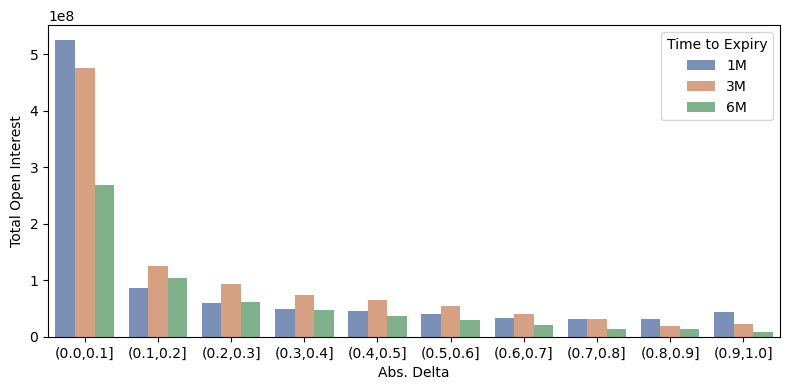

In [120]:
# Plot the data using seaborn
fig, ax = plt.subplots(figsize=(8, 4))
open_interest_combined_melted = open_interest_combined.melt(id_vars='delta', var_name='Time to Expiry', value_name='Total Open Interest')
sns.set_palette('deep')
sns.barplot(data=open_interest_combined_melted, x='delta', y='Total Open Interest', hue='Time to Expiry', ax=ax, alpha=0.8)
ax.set_xlabel('Abs. Delta')
ax.set_ylabel('Total Open Interest')
plt.tight_layout()
plt.show()
# plt.savefig('open_interest_by_delta_brackets.png')
# plt.close()

In [103]:
# Define the delta brackets
delta_brackets = pd.cut(dat['delta'].abs(), bins=np.linspace(0, 1, 11), labels=[f'({i:.1f},{i+0.1:.1f}]' for i in np.linspace(0, 0.9, 10)])

In [104]:
# Filter data for the specified time to expiry
expiry_30 = dat[dat['time_to_expiry'] <= 30]
expiry_90 = dat[(dat['time_to_expiry'] > 30) & (dat['time_to_expiry'] <= 90)]
expiry_180 = dat[(dat['time_to_expiry'] > 90) & (dat['time_to_expiry'] <= 180)]

In [105]:
# Group by delta brackets and calculate total open interest
vlm_30 = expiry_30.groupby(delta_brackets)['volume'].mean().reset_index(name='1M')
vlm_90 = expiry_90.groupby(delta_brackets)['volume'].mean().reset_index(name='3M')
vlm_180 = expiry_180.groupby(delta_brackets)['volume'].mean().reset_index(name='6M')

In [106]:
# Merge the dataframes
vlm_combined = pd.concat([
        vlm_30.set_index('delta'), 
        vlm_90.set_index('delta'), 
        vlm_180.set_index('delta')
    ], axis=1, join='outer').reset_index()

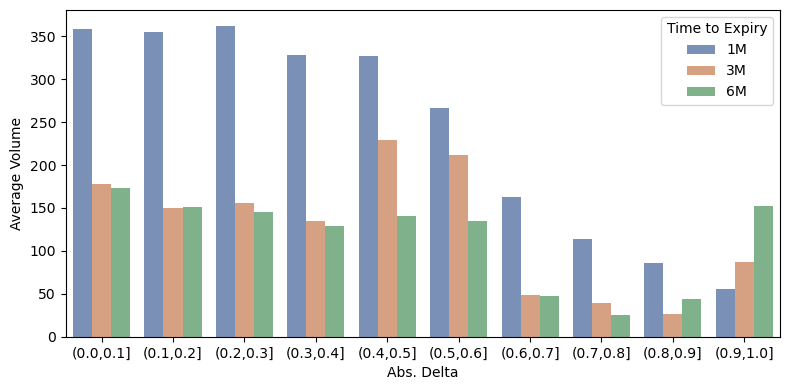

In [121]:
# Plot the data using seaborn
fig, ax = plt.subplots(figsize=(8, 4))
vlm_combined_melted = vlm_combined.melt(id_vars='delta', var_name='Time to Expiry', value_name='Average Volume')
sns.set_palette('deep')
sns.barplot(data=vlm_combined_melted, x='delta', y='Average Volume', hue='Time to Expiry', ax=ax, alpha=0.8)
ax.set_xlabel('Abs. Delta')
ax.set_ylabel('Average Volume')
plt.tight_layout()
plt.show()
# plt.savefig('open_interest_by_delta_brackets.png')
# plt.close()

## Others

In [70]:
# Create a function for density plots
def create_density_plots(data, columns, hue=None):
    n = len(columns)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))

    for i, col in enumerate(columns):
        if hue is None:
            sns.kdeplot(data=data, x=col, fill=True, ax=axes[i])
        else:
            sns.kdeplot(data=data, x=col, hue=hue, fill=True, common_norm=False, ax=axes[i])

        axes[i].set_title(f'Density Plot of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    return fig

In [71]:
# 1. Density plots of key metrics
metrics = ['impl_volatility', 'volume', 'delta', 'gamma', 'vega', 'theta']

# Overall density plots
fig_density = create_density_plots(dat, metrics)
plt.savefig('density_plots_overall.png')
plt.close()
# Density plots by expiry indicator
fig_density_by_expiry = create_density_plots(dat, metrics, hue='expiry_indicator')
plt.savefig('density_plots_by_expiry.png')
plt.close()

In [72]:
# 2. Analysis of bid-ask spread
fig, ax = plt.subplots(figsize=(12, 8))

# Histogram of percentage bid-ask spread
sns.histplot(data=dat, x='bid_ask_spread_pct', kde=True)
ax.set_title('Distribution of Bid-Ask Spread (%)')
ax.set_xlabel('Spread (%)')
ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('bid_ask_spread_analysis.png')
plt.close()

# Bid-ask spread by strike price and time to expiry
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(dat['strike_price'], dat['time_to_expiry'],
                     c=dat['bid_ask_spread_pct'], cmap='viridis',
                     alpha=0.6, s=dat['volume']/100, norm=LogNorm())
ax.set_title('Bid-Ask Spread (%) by Strike Price and Time to Expiry')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiry (days)')
plt.colorbar(scatter, label='Bid-Ask Spread (%)')
plt.savefig('bid_ask_spread_by_strike_expiry.png')
plt.close()


# Vol

## Surface

In [110]:
daily_volume = dat.groupby('date')['volume'].sum().reset_index()
high_volume_dates = daily_volume.nlargest(5, 'volume')
print("Top 5 dates with highest trading volume:")
print(high_volume_dates)

Top 5 dates with highest trading volume:
          date   volume
131 2023-03-10  2359735
16  2022-09-23  2269301
208 2023-06-30  2267439
189 2023-06-02  2036707
30  2022-10-13  2020963


In [126]:
def plot_vol_surface(data, date):
    # Filter data for the specific date and call options
    date_data = data[(data['date'] == date) & (data['cp_flag'] == 'C')]

    if len(date_data) < 10:  # Ensure we have enough data points
        print(f"Not enough data for date {date}")
        return None

    # Remove outliers that might distort the surface
    q1 = date_data['impl_volatility'].quantile(0.05)
    q3 = date_data['impl_volatility'].quantile(0.95)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = date_data[(date_data['impl_volatility'] >= lower_bound) &
                              (date_data['impl_volatility'] <= upper_bound)]

    # Check if we still have enough data after filtering
    if len(filtered_data) < 10:
        print(f"Not enough data after outlier removal for date {date}")
        return None

    # Sort data by strike price and time to expiry for better visualization
    filtered_data = filtered_data.sort_values(['strike_price', 'time_to_expiry'])

    # Normalize strike price to make the surface more meaningful
    # Use moneyness (strike/forward) if available, otherwise normalize around the mean
    if 'moneyness' in filtered_data.columns and filtered_data['moneyness'].notna().all():
        x_values = filtered_data['moneyness'].values
        x_label = 'Moneyness (Strike/Forward)'
    else:
        mean_strike = filtered_data['strike_price'].mean()
        x_values = filtered_data['strike_price'].values / mean_strike
        x_label = 'Normalized Strike Price'

    y_values = filtered_data['time_to_expiry'].values
    z_values = filtered_data['impl_volatility'].values

    # Create a more uniform grid
    x_min, x_max = np.min(x_values), np.max(x_values)
    y_min, y_max = np.min(y_values), np.max(y_values)

    # Create a mesh grid
    x_grid = np.linspace(x_min, x_max, 50)
    y_grid = np.linspace(y_min, y_max, 50)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Try different interpolation methods
    try:
        # First try cubic interpolation
        Z = griddata((x_values, y_values), z_values, (X, Y), method='cubic')

        # If cubic interpolation has too many NaN values, fall back to linear
        if np.isnan(Z).sum() > 0.3 * Z.size:
            Z = griddata((x_values, y_values), z_values, (X, Y), method='linear')

        # If still too many NaN values, use nearest
        if np.isnan(Z).sum() > 0.3 * Z.size:
            Z = griddata((x_values, y_values), z_values, (X, Y), method='nearest')
    except Exception as e:
        print(f"Interpolation error: {e}")
        # Fall back to nearest as a last resort
        Z = griddata((x_values, y_values), z_values, (X, Y), method='nearest')

    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis',
                          linewidth=0, antialiased=True, alpha=0.8)

    # Add scatter points of actual data
    scatter = ax.scatter(x_values, y_values, z_values,
                         c=z_values, cmap='viridis',
                         s=filtered_data['volume']/filtered_data['volume'].max()*100+20,
                         alpha=0.6, edgecolors='black')

    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel('Time to Expiry (days)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'Implied Volatility Surface on {date.strftime("%Y-%m-%d")}')

    # Improve view angle
    ax.view_init(30, 45)

    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Implied Volatility')

    # Save high-quality figure
    plt.savefig(f'vol_surface_{date.strftime("%Y%m%d")}.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.close()

    # # Create an additional 2D contour plot for better visualization
    # fig, ax = plt.subplots(figsize=(12, 8))
    # contour = ax.contourf(X, Y, Z, 20, cmap='viridis')
    # ax.scatter(x_values, y_values, c=z_values, cmap='viridis',
    #            s=filtered_data['volume']/filtered_data['volume'].max()*100+20,
    #            alpha=0.6, edgecolors='black')

    # plt.colorbar(contour, label='Implied Volatility')
    # ax.set_xlabel(x_label)
    # ax.set_ylabel('Time to Expiry (days)')
    # ax.set_title(f'Implied Volatility Contour on {date.strftime("%Y-%m-%d")}')
    # plt.savefig(f'vol_contour_{date.strftime("%Y%m%d")}.png', dpi=300)#, bbox_inches='tight')
    # plt.close()

    return fig

In [ ]:
# Plot implied volatility surfaces for high volume dates
for _, row in high_volume_dates.iterrows():
    plot_vol_surface(dat, row['date'])

## TS volatility

In [129]:

# Additional analysis: Time series of implied volatility by moneyness
# Calculate moneyness (assuming SPX spot price is the average of ATM options strike)
def calculate_moneyness(row):
    if pd.isna(row['forward_price']):
        # If forward price is not available, use a proxy
        # This is a simplified approach - in reality you'd use the actual spot price
        return row['strike_price'] / 1000  # Example scaling, replace with actual logic
    else:
        return row['strike_price'] / row['forward_price']

dat['moneyness'] = dat.apply(calculate_moneyness, axis=1)

In [ ]:

# Group data by date and moneyness category
def moneyness_category(m):
    if m < 0.95:
        return 'Deep OTM'
    elif m < 0.98:
        return 'OTM'
    elif m < 1.02:
        return 'ATM'
    elif m < 1.05:
        return 'ITM'
    else:
        return 'Deep ITM'

dat['moneyness_category'] = dat['moneyness'].apply(moneyness_category)

# Calculate average implied volatility by date and moneyness category
vol_by_date_moneyness = dat.groupby(['date', 'moneyness_category'])['impl_volatility'].mean().reset_index()
vol_pivot = vol_by_date_moneyness.pivot(index='date', columns='moneyness_category', values='impl_volatility')

# Plot time series
plt.figure(figsize=(12, 8))
for column in vol_pivot.columns:
    plt.plot(vol_pivot.index, vol_pivot[column], label=column)

plt.title('Implied Volatility by Moneyness Over Time')
plt.xlabel('Date')
plt.ylabel('Average Implied Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('iv_by_moneyness_time_series.png')
plt.close()


# Statistics

In [151]:
# Function to create summary statistics tables
def summary_statistics(data, group_col=None):
    metrics = ['time_to_expiry', 'moneyness', 'bid_ask_spread_pct', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta']

    if group_col:
        result = data.groupby(group_col)[metrics].agg(['mean', 'median', 'min', 'max', 'std', 'size'])
        result = {k : v.stack().droplevel(0) for k, v in result.groupby(level=0, axis=0)}
    else:
        result = data[metrics].agg(['mean', 'median', 'min', 'max', 'std', 'size']).reset_index()

    return result

In [152]:
summary_statistics(dat, 'cp_flag')

{'C':         time_to_expiry      moneyness  bid_ask_spread_pct  impl_volatility  \
 mean         77.328102    4235.421301            6.368024         0.186488   
 median       32.000000    4190.000000            1.587302         0.177066   
 min           1.000000     100.000000            0.000000         0.032648   
 max        2002.000000   12000.000000          184.000000         8.916361   
 std         135.229608     462.821309           15.528479         0.088362   
 size     644979.000000  644979.000000       644979.000000    644979.000000   
 
                 delta          gamma           vega          theta  
 mean         0.377134       0.001416     413.034466    -435.167242  
 median       0.351380       0.001063     313.217400    -334.641900  
 min          0.000350       0.000000       0.123417   -8681.899000  
 max          0.995979       0.019950    3782.842000     110.516300  
 std          0.287090       0.001330     387.065266     470.406355  
 size    644979.0000

In [ ]:

# Create summary statistics overall and by expiry type
overall_stats = summary_statistics(dat)
expiry_stats = summary_statistics(dat, 'expiry_indicator')
put_call_stats = summary_statistics(dat, 'cp_flag')

# Save to CSV
overall_stats.to_csv('overall_summary_stats.csv', index=False)
expiry_stats.to_csv('expiry_summary_stats.csv', index=False)
put_call_stats.to_csv('put_call_summary_stats.csv', index=False)

In [148]:
[(_, group.stack().droplevel(0)) for _, group in put_call_stats.set_index('cp_flag').groupby(level=0, axis=0)]

[('C',
          time_to_expiry      moneyness  bid_ask_spread_pct  impl_volatility  \
  mean         77.328102    4235.421301            6.368024         0.186488   
  median       32.000000    4190.000000            1.587302         0.177066   
  min           1.000000     100.000000            0.000000         0.032648   
  max        2002.000000   12000.000000          184.000000         8.916361   
  std         135.229608     462.821309           15.528479         0.088362   
  size     644979.000000  644979.000000       644979.000000    644979.000000   
  
                  delta          gamma           vega          theta  
  mean         0.377134       0.001416     413.034466    -435.167242  
  median       0.351380       0.001063     313.217400    -334.641900  
  min          0.000350       0.000000       0.123417   -8681.899000  
  max          0.995979       0.019950    3782.842000     110.516300  
  std          0.287090       0.001330     387.065266     470.406355  
  si

In [19]:

# Visualize the smile effect for a specific date (using the highest volume date)
highest_vol_date = high_volume_dates.iloc[0]['date']
smile_data = dat[dat['date'] == highest_vol_date]

# Group by time to expiry and create separate plots
unique_expiries = smile_data['time_to_expiry'].unique()
unique_expiries.sort()

for expiry in unique_expiries[:5]:  # Limit to first 5 expiries to avoid too many plots
    expiry_data = smile_data[smile_data['time_to_expiry'] == expiry]
    if len(expiry_data) < 5:
        continue

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=expiry_data, x='moneyness', y='impl_volatility',
                    hue='cp_flag', size='volume', sizes=(20, 200))
    plt.title(f'Volatility Smile for {highest_vol_date.strftime("%Y-%m-%d")} (Days to Expiry: {expiry})')
    plt.xlabel('Moneyness (Strike/Forward)')
    plt.ylabel('Implied Volatility')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'vol_smile_{highest_vol_date.strftime("%Y%m%d")}_exp_{expiry}.png')
    plt.close()
